> "…when you have eliminated the impossible, whatever remains, however improbable, must be the truth"

> -Sir Arthur Conan Doyle

![](https://i.pinimg.com/originals/e7/b8/df/e7b8dfcca0a5383d99142f28b3a6f51d.jpg)

### **The Challenge:**
If you have two sentences, there are three ways they could be related: one could entail the other, one could contradict the other, or they could be unrelated. Natural Language Inferencing (NLI) is a popular NLP problem that involves determining how pairs of sentences (consisting of a premise and a hypothesis) are related.

Your task is to create an NLI model that assigns labels of 0, 1, or 2 (corresponding to entailment, neutral, and contradiction) to pairs of premises and hypotheses. To make things more interesting, the train and test set include text in fifteen different languages! You can find more details on the dataset by reviewing the Data page.

I have always felt like EDA notebooks on kaggle have lost its main motive and that is to explain the Data. It is more about fancy graph then the meaning behind it. I hope I fulfill it.


Let us walk through the directory.

In [1]:
!pip install  -q wordcloud

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import pandas as pd
import os
print('Inside Input we have:')
for i, (dirname, _, filenames) in enumerate(os.walk('/kaggle/input/contradictory-my-dear-watson')):
    print('\t '* i, '{}) {} folder. It has:-'.format(i+1, dirname.split('/')[-1]))
    for idx,filename in enumerate(filenames):
        print('\t '* (i+1),f'{idx+1}. {filename}' )


Inside Input we have:
 1) contradictory-my-dear-watson folder. It has:-
	  1. test.csv
	  2. sample_submission.csv
	  3. train.csv


Now let us load our CSV files and do some

In [3]:
train_df = pd.read_csv('../input/contradictory-my-dear-watson/train.csv')
test_df = pd.read_csv('../input/contradictory-my-dear-watson/test.csv')
train_df.shape, test_df.shape

((12120, 6), (5195, 5))

In [4]:
train_df.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


In [5]:
test_df.head()

,id,premise,hypothesis,lang_abv,language
0,c6d58c3f69,بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",ur,Urdu
1,cefcc82292,هذا هو ما تم نصحنا به.,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...,ar,Arabic
2,e98005252c,et cela est en grande partie dû au fait que le...,Les mères se droguent.,fr,French
3,58518c10ba,与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp,IMA与其他组织合作，因为它们都依靠共享资金。,zh,Chinese
4,c32b0d16df,Она все еще была там.,"Мы думали, что она ушла, однако, она осталась.",ru,Russian


#### Note to ourself: ***It looks like Multi-Lingual, Multi-Class Problem.***

 ### First let us analyze label or target
 They are classifying pairs of sentences (consisting of a premise and a hypothesis) into three categories - 
 
 **1. entailment means logical sequence**
 
 **2. contradiction means illogical sequence**  
 
 **3. neutral means niether logical or illogical sequence**

#### EXAMPLE
As explained in Getting Started.
> He came, he opened the door and I remember looking back and seeing the expression on his face, and I could tell that he was disappointed.

###### Hypothesis 1:

> Just by the look on his face when he came through the door I just knew that he was let down.

We know that this is true based on the information in the premise. So, this pair is related by **entailment**.

###### Hypothesis 2:

> He was trying not to make us feel guilty but we knew we had caused him trouble.

This very well might be true, but we can’t conclude this based on the information in the premise. So, this relationship is **neutral**.

###### Hypothesis 3:

> He was so excited and bursting with joy that he practically knocked the door off it's frame.

We know this isn’t true, because it is the complete opposite of what the premise says. So, this pair is related by **contradiction**

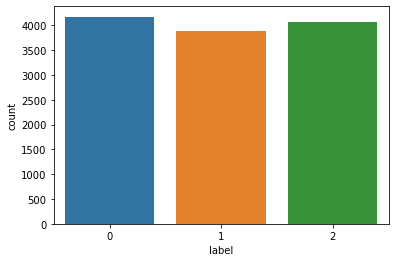

In [6]:
import seaborn as sns
sns.countplot(train_df.label);

#### Note to ourself: In terms of Labels, it is a **Multi Class Balanced** Dataset Problem.

### Now let us move forward and analyze language variable 

Let see different language we are dealing with:-

In [7]:
print('Different types of language are', train_df['language'].unique(), '\nTotal number of Languages are:-',len((train_df['language'].unique())))

Different types of language are ['English' 'French' 'Thai' 'Turkish' 'Urdu' 'Russian' 'Bulgarian' 'German'
 'Arabic' 'Chinese' 'Hindi' 'Swahili' 'Vietnamese' 'Spanish' 'Greek'] 
Total number of Languages are:- 15


We have 
Arabic, Bulgarian, Chinese, German, Greek, English, Spanish, French, Hindi, Russian, Swahili, Thai, Turkish, Urdu, and Vietnamese.

In [8]:
import plotly.express as px
import matplotlib.pyplot as plt

name, count = np.unique(train_df['language'], return_counts = True)
fig = px.pie( values= count, names=name, title='Languages Available to us.')
fig.update_traces(hoverinfo='value+label+percent', textposition='inside', textfont_size=15,textinfo = 'value + label',
                  marker=dict( line=dict(color='#000100', width=2)))
fig.show()

In [9]:
name, count = np.unique(train_df[train_df['language'] != 'English'].language, return_counts = True)

fig = px.bar(x=name, y=count)
fig.update_traces(texttemplate='%{y:.2s}',  textposition='outside')
fig.update_layout(uniformtext_minsize=15, uniformtext_mode='hide', xaxis_tickangle=-80)
fig.show()

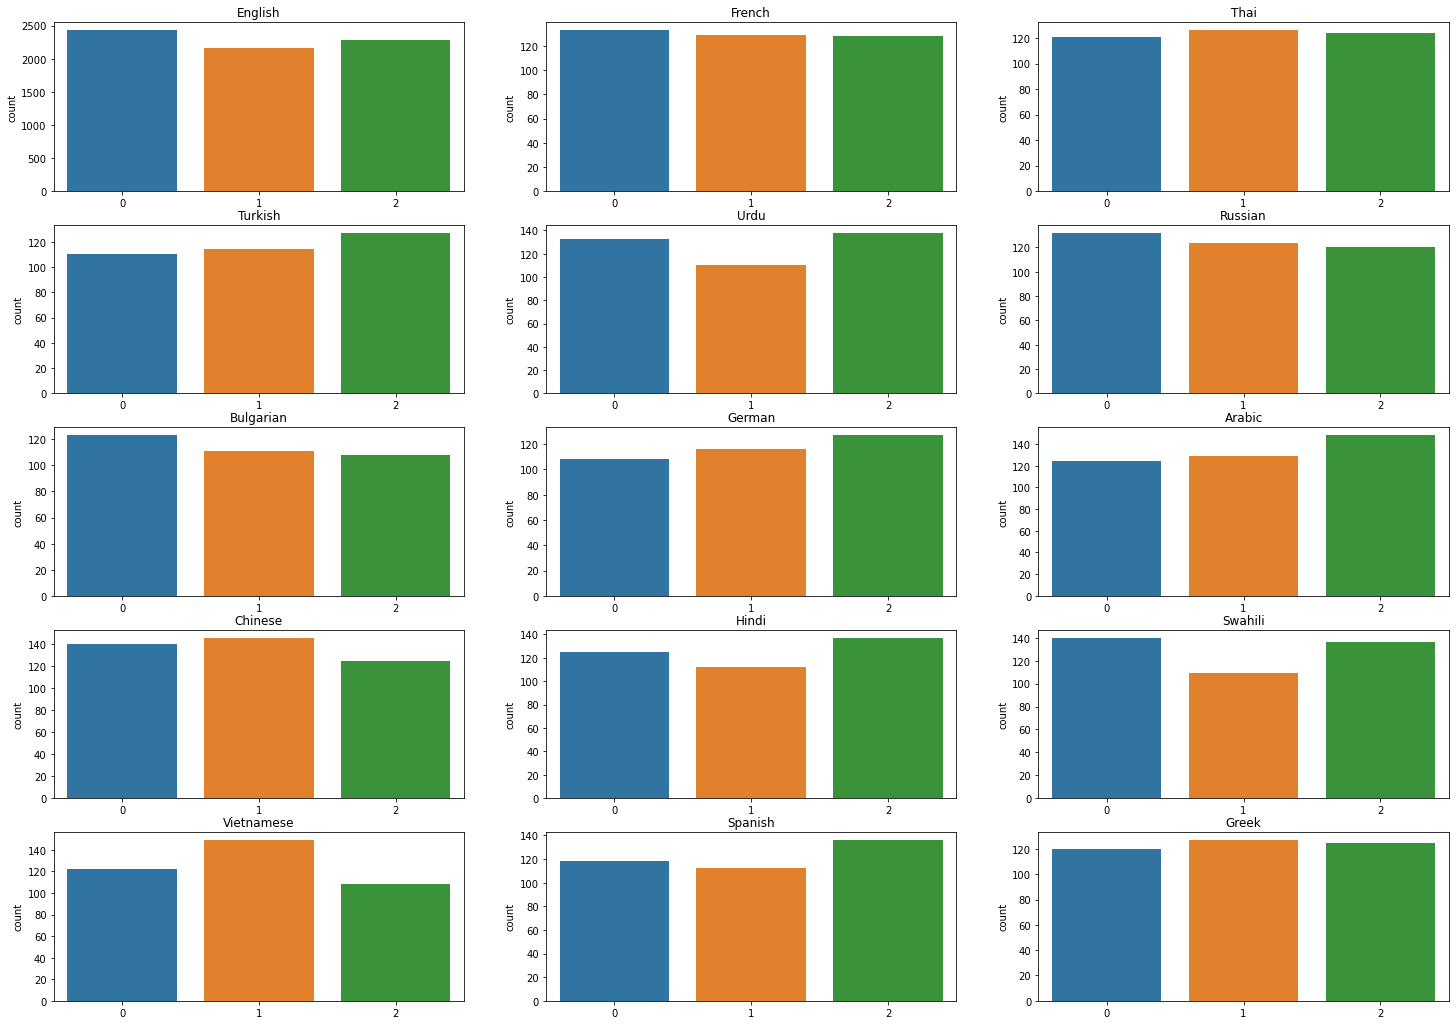

In [10]:
fig = plt.figure(figsize = (25,18))
for i,n in enumerate(train_df.language.unique()):
    ax1 = plt.subplot(5,3,i+1)
    sns.countplot(train_df[train_df.language == n].label, ax =ax1)
    ax1.set_title(n)
    ax1.set_xlabel('')


#### Note to ourself: It is fairly a balanced Dataset if we seperate English and other Languages.

### Now let us move forward and analyze Text portion.

In [11]:
import wordcloud

In [12]:
text = train_df[train_df.language == 'English'].premise.to_string()

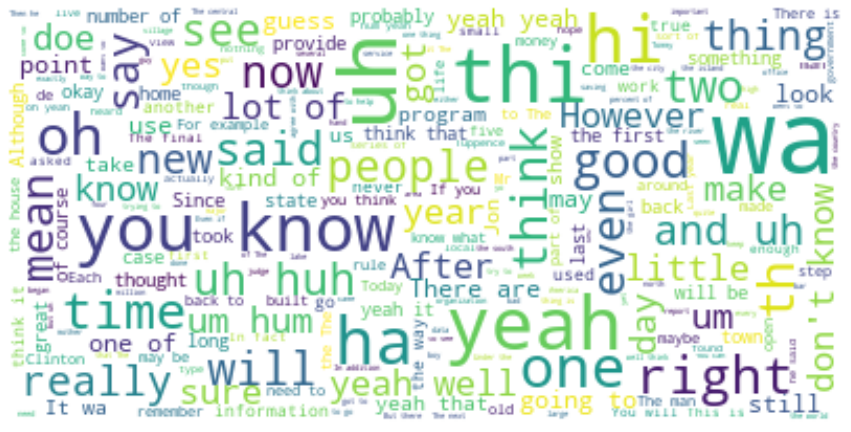

In [13]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
stopwords.update(["many", "alway", "you", "many", "well", 'time, mean', 'much'])
wordcloud = WordCloud(stopwords=stopwords,max_font_size=50, max_words=800, background_color="white").generate(text)

# Display the generated image:
plt.figure(figsize = (15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Min and Max of len of strings in Premise and hypothesis.

In [14]:
print('max length of sentence in premise', max(train_df.premise.apply(lambda x:len(x.split(' ')))))
print('min length of sentence in premise',min(train_df.premise.apply(lambda x:len(x.split(' ')))))
print('max length of sentence in hypothesis',max(train_df.hypothesis.apply(lambda x:len(x.split(' ')))))
print('min length of sentence in hypothesis',min(train_df.hypothesis.apply(lambda x:len(x.split(' ')))))

max length of sentence in premise 196
min length of sentence in premise 1
max length of sentence in hypothesis 58
min length of sentence in hypothesis 1


Things we have learned about about dataset are:
* Multi Class
* Multi Lingual
* Balanced Dataset